## 测试网络效果

### 加载训练好的模型

In [98]:

import torch
from torchvision import models
from torch import nn

import my_model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            # 把模型的所有层的参数的 requires_grad 属性设置为 false，表示不再对原本的参数进行训练
            param.requires_grad = False

def initialize_model(model_name, num_classes=3, feature_extract=False, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == 'myResnet':
        model_ft = my_model.ResNet()
        
        input_size = 224
    elif model_name == 'resnet34':
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes),
                                    nn.LogSoftmax(dim=1))
        input_size = 224
    elif model_name == 'resnet101':
        model_ft = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes),
                                    nn.LogSoftmax(dim=1))
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()


    return model_ft, input_size

In [99]:
# 初始化模型
model_name = 'myResnet'
num_classes = 3
feature_extract = False
use_pretrained = True
model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 加载 checkpoint 文件
checkpoint = torch.load('checkpoint_myResnet_1_30/checkpoint.pth')
best_acc = checkpoint['best_acc']
print(best_acc)
# 加载训练好的参数
model.load_state_dict(checkpoint['state_dict'])

tensor(0.9449, device='cuda:0', dtype=torch.float64)


<All keys matched successfully>

### 测试数据预处理

In [100]:
def process_image(image_path, image_size=256, image_crop_size=224):
    # 读取测试数据
    img = Image.open(image_path)
    # 将图像对象 img 转换为RGB颜色模式（如果它原本不是这种颜色模式）
    img = img.convert('RGB')
    # Resize,thumbnail方法只能进行缩小，所以进行了判断
    # 如果图片宽度大于高度
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, image_size))
    else:
        img.thumbnail((image_size, 10000))

    # 如果不传入 image_crop_size 则表示不进行裁剪操作
    if image_crop_size is None:
        image_crop_size = image_size

    # Crop操作
    left_margin = (img.width-image_crop_size)/2
    bottom_margin = (img.height-image_crop_size)/2
    right_margin = left_margin + image_crop_size
    top_margin = bottom_margin + image_crop_size
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # 相同的预处理方法
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # 注意颜色通道应该放在第一个位置
    img = img.transpose((2, 0, 1))
    
    return img

### 展示数据

In [101]:
import numpy as np 
from PIL import Image
from matplotlib import pyplot as plt


In [102]:
def imshow(image, ax=None, title=None):
    """展示数据"""
    if ax is None:
        fig, ax = plt.subplots()
    
    # 颜色通道还原
    image = np.array(image).transpose((1, 2, 0))
    
    # 预处理还原
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.set_title(title)
    
    return ax

<Axes: >

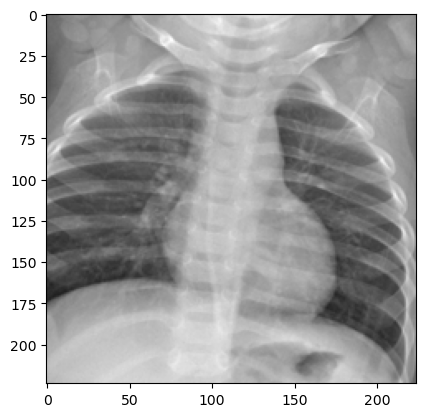

In [103]:
image_path = 'data/valid/NORMAL/NORMAL(1281).jpg'
img = process_image(image_path)
imshow(img)

In [104]:
img.shape

(3, 224, 224)

### 开始测试

In [105]:
if img is not None:
    print('not none')

not none


In [106]:
# 将模型设置为测试模式
model.eval()

img = torch.from_numpy(img)  # 将 numpy 数组转化为 tensor
img = img.float()
# print(img.shape)
img = img.unsqueeze(0)  # 添加 batch 维度
# print(img.shape)

In [107]:
img = img.to(device)

output = model(img)
print(output.shape)
print(output)

torch.Size([1, 3])
tensor([[-7.4540,  5.0320, -0.1078]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [108]:
from torch.nn import functional as F 
p = F.softmax(output, dim=1)
p = p*100
p = p.cpu()
# 在PyTorch中，detach() 方法用于从计算图中分离张量，返回一个新的张量，该张量不再具有梯度信息
p = p.detach().numpy()
p = p.flatten()
print(p)

[3.757231e-04 9.941715e+01 5.824663e-01]


In [109]:
n1, n2, n3 = p
print(n1, n2, n3)

0.0003757231 99.41715 0.5824663
